### This project has been created and implemented as a learning experience on creating effective machine learning models and effective data pre-processing with heavily imbalanced data.  It is also meant to be an exploration into understanding fraud and implementing AI to combat it.  I am using the techniques learned here to apply to a separate data set on insurance fraud and will post the results once there is a MVP (Minimum Viable Product).  


References- most of this project heavily copied techniques implemented and discussed in the following Kaggle kernels and online articles linked below.  My thanks to Janio Martinez, Lukas Frei, Dataman, and Breya Walker for sharing their insights and techniques

https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets


https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-i-under-sampling-a8dbc3d8d6d8


https://towardsdatascience.com/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879


https://towardsdatascience.com/detecting-credit-card-fraud-using-machine-learning-a3d83423d3b8

https://medium.com/@breya.heysoftware/synthetic-minority-over-sampling-technique-smote-from-scratch-e1167f788434

### Link to the credit card fraud dataset https://www.kaggle.com/mlg-ulb/creditcardfraud

In [128]:
#the dataset can be found at: https://www.kaggle.com/mlg-ulb/creditcardfraud


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#clustering and preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches

#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#libraries to make life a little easier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import warnings
import os
from os import listdir, getcwd
from scipy.stats import norm
from sklearn.model_selection import KFold, StratifiedKFold



# Read the Data and begin exploratory analysis of the dataset

In [48]:
Maindf = pd.read_csv("../Dataset/creditcard.csv")

In [49]:
Maindf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Get the shape of the dataset to see how many datapoints are in the dataset: 280k with 31 features 
Since PCA has already been performed on the dataset according to Kaggle, no need to focus on further dimensionality reduction

In [50]:
Maindf.shape

(284807, 31)

### Based on information on the dataset, 2 days worth of transactions are captured here:  (172792 sec/60 sec/60 min/ 24 hours) = 1.999 days

In [51]:
Maindf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### No null values in the dataset

In [52]:
Maindf.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Look at the breakdwon between positive and negative instances: This shows a heavily skewed dataset with over 99% of the data being non fraudulent

In [53]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(Maindf['Class'].value_counts()[0]/len(Maindf) * 100,2), '% of the dataset')
print('Frauds', round(Maindf['Class'].value_counts()[1]/len(Maindf) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


In [54]:
print('Count of No Frauds: ', round(Maindf['Class'].value_counts()[0]))
print('Count of Frauds: ', round(Maindf['Class'].value_counts()[1]))


Count of No Frauds:  284315
Count of Frauds:  492


In [55]:
Maindf.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

## Let's look at transaction distr and trans timing of fraudulent transactions

In [56]:
fraudDF = Maindf[Maindf.Class ==1]
fraudDF

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,...,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6334,7535.0,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,...,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,...,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6338,7551.0,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,...,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1
6427,7610.0,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,...,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1


In [57]:
non_fraud_df = Maindf[Maindf.Class==0]

## Let's see if there's any noticeable differences in the timing or the values of fraudulent vs non-fraudulent transactions

C:\Users\karan\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Time(s)')

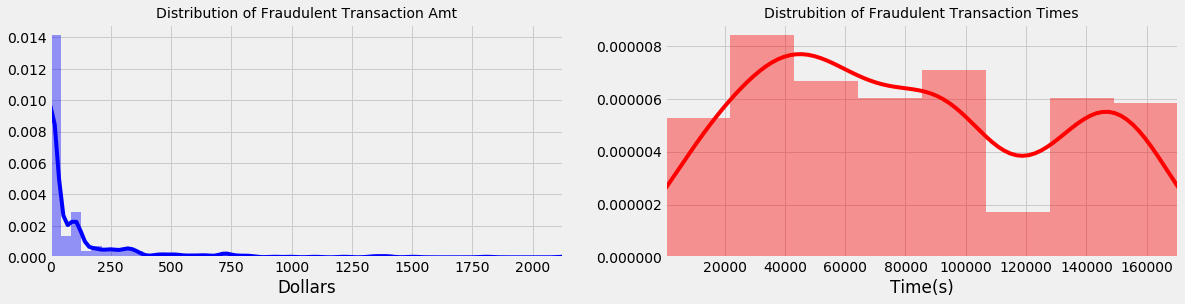

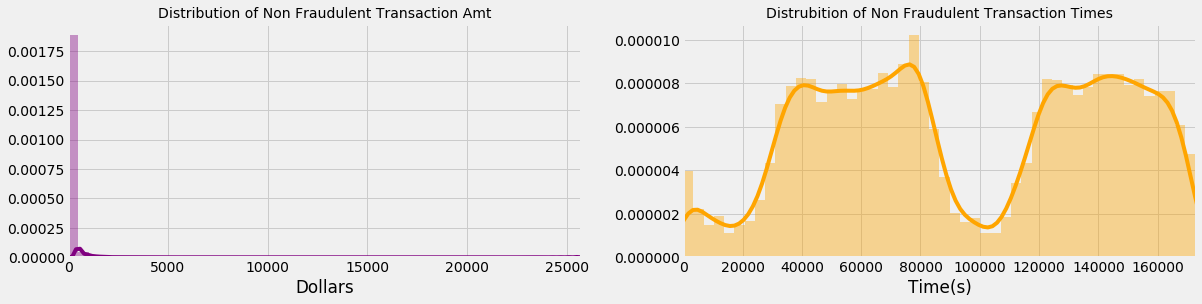

In [58]:
%matplotlib inline 
plt.style.use('fivethirtyeight')

fig, ax = plt.subplots(1,2, figsize = (18,4))

amount_val = fraudDF['Amount'].values
time_val = fraudDF['Time'].values

sns.distplot(amount_val, ax=ax[0], color='b')
ax[0].set_title('Distribution of Fraudulent Transaction Amt', fontsize = 14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set_xlabel('Dollars')


sns.distplot(time_val, ax=ax[1], color='r')
ax[1].set_title('Distrubition of Fraudulent Transaction Times', fontsize = 14)
ax[1].set_xlim([min(time_val), max(time_val)])
ax[1].set_xlabel('Time(s)')


fig, ax = plt.subplots(1,2, figsize = (18,4))

non_fraud_amount_val = non_fraud_df['Amount'].values
non_fraud_time_val = non_fraud_df['Time'].values

sns.distplot(non_fraud_amount_val, ax=ax[0], color='purple')
ax[0].set_title('Distribution of Non Fraudulent Transaction Amt', fontsize = 14)
ax[0].set_xlim([min(non_fraud_amount_val), max(non_fraud_amount_val)])
ax[0].set_xlabel('Dollars')


sns.distplot(non_fraud_time_val, ax=ax[1], color='orange')
ax[1].set_title('Distrubition of Non Fraudulent Transaction Times', fontsize = 14)
ax[1].set_xlim([min(non_fraud_time_val), max(non_fraud_time_val)])
ax[1].set_xlabel('Time(s)')



## Let's look at a summary of the two separated dataframes

In [59]:
fraudDF.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,...,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,...,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,...,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,...,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,...,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0


In [60]:
non_fraud_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,...,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.000000,284315.0
mean,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,-0.001235,-0.000024,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,0.0
std,47484.015786,1.929814,1.636146,1.459429,1.399333,1.356952,1.329913,1.178812,1.161283,1.089372,...,0.716743,0.723668,0.621541,0.605776,0.520673,0.482241,0.399847,0.329570,250.105092,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54230.000000,-0.917544,-0.599473,-0.884541,-0.850077,-0.689398,-0.766847,-0.551442,-0.208633,-0.640412,...,-0.228509,-0.542403,-0.161702,-0.354425,-0.317145,-0.327074,-0.070852,-0.052950,5.650000,0.0
50%,84711.000000,0.020023,0.064070,0.182158,-0.022405,-0.053457,-0.273123,0.041138,0.022041,-0.049964,...,-0.029821,0.006736,-0.011147,0.041082,0.016417,-0.052227,0.001230,0.011199,22.000000,0.0
75%,139333.000000,1.316218,0.800446,1.028372,0.737624,0.612181,0.399619,0.571019,0.326200,0.598230,...,0.185626,0.528407,0.147522,0.439869,0.350594,0.240671,0.090573,0.077962,77.050000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


#### A few interesting things from the fraud dataframe compared to the non-fraud dataframe:

In [61]:
comparison_series = pd.Series(['Mean', 'Max', 'Min', 'Standard_Dev'])
fraud_series = pd.Series([fraudDF['Amount'].mean(axis=0).round(2),fraudDF['Amount'].max().round(2),fraudDF['Amount'].min().round(2), fraudDF['Amount'].std().round(2)])
non_fraud_series = pd.Series([non_fraud_df['Amount'].mean(axis=0).round(2), non_fraud_df['Amount'].max().round(2), non_fraud_df['Amount'].min().round(2), non_fraud_df['Amount'].std().round(2)])

comparison_df = pd.concat([fraud_series, non_fraud_series], axis = 1)
comparison_df.columns=['fraud', 'non_fraud']
comparison_df.rename(index={0:'Mean', 1:'Max', 2:'Min', 3:'Standard_Dev'}, inplace=True)

comparison_df

,fraud,non_fraud
Mean,122.21,88.29
Max,2125.87,25691.16
Min,0.00,0.00
Standard_Dev,256.68,250.11


##### It is difficult to say whether there is any strong correlations yet, but it is interesting to see that fraudulent purchases are, on average, higher than non fraudulent ones.  Combine that with the other interesting note that fraudulent purchases seem to have a similar purchase timeline as non fraudulent ones.  I would have expected that fraudulent purchases to be made at more random times across the board, but perhaps the fact that they mirror normal purchases means that most fraudulent purchases are not at least international.  Perhaps that means that the majority of fraud is because of domestic thieves instead of international hackers.  However, I won't speculate further without more analysis.

## Now scale Amount and Dollars so that trained features aren't too heavily swayed by the range of values in the Amount and Times

In [62]:
from sklearn.preprocessing import StandardScaler, RobustScaler

rob_scaler = RobustScaler()

Maindf['scaled_amount'] = rob_scaler.fit_transform(Maindf['Amount'].values.reshape(-1,1))
Maindf['scaled_time'] = rob_scaler.fit_transform(Maindf['Time'].values.reshape(-1,1))

Maindf.drop(['Time', 'Amount'], axis=1, inplace = True)


In [63]:
scaled_amount = Maindf['scaled_amount']
scaled_time = Maindf['scaled_time']

Maindf.drop(['scaled_amount', 'scaled_time'], axis = 1, inplace = True)
Maindf.insert(0, 'scaled_amount', scaled_amount)
Maindf.insert(1, 'scaled_time', scaled_time)

Maindf.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Now let's set aside the training and testing data.  We will use the same data for each of the ML models implemented to see how each perform on the same data

In [64]:
y = Maindf.Class

In [65]:
X=Maindf.drop(['Class'], axis = 1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)

## Since i will reuse the training and testing sets for multiple algorithms and since the sets themselves have a similar distribution of fraud to non-fraud, i will use the standard train test split approach

In [67]:
print('Count of No Frauds in traning: ', (y_train.value_counts()[0]))
print('Count of Frauds in training: ', (y_train.value_counts()[1]))

print('Count of No Frauds in testing: ', (y_test.value_counts()[0]))
print('Count of Frauds in testing: ', (y_test.value_counts()[1]))

print('percentage of fraud in traning set ' + str(100 *(402/227443)) + ' %')
print('percentage of fraud in testing set ' + str(100 * (90/56872))+ ' %')

Count of No Frauds in traning:  227443
Count of Frauds in training:  402
Count of No Frauds in testing:  56872
Count of Frauds in testing:  90
percentage of fraud in traning set 0.1767475807125302 %
percentage of fraud in testing set 0.15825010550007032 %


In [68]:
#shuffle the entire dataset
Maindf = Maindf.sample(frac=1)

In [69]:
#take random sample of 402 fraud 
fraud_train = Maindf.loc[Maindf['Class'] == 1]
fraud_train = fraud_train.drop(fraud_train.index[402:492])
non_fraud_train = Maindf.loc[Maindf['Class'] == 0][:402]

In [70]:
training_df = pd.concat([fraud_train, non_fraud_train], axis = 0)

In [71]:
training_df = training_df.sample(frac=1, random_state = 13)
training_df.head()
training_df.loc[training_df['Class'] == 1]

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
10690,16.724516,-0.782481,-12.224021,3.854150,-12.466766,9.648311,-2.726961,-4.445610,-21.922811,0.320792,...,-2.147181,-1.159830,-1.504119,-19.254328,0.544867,-4.781606,-0.007772,3.052358,-0.775036,1
243393,-0.307273,0.789765,-5.488032,3.329561,-5.996296,3.601720,-2.023926,-1.737393,-4.396859,0.228394,...,-0.551121,1.719631,0.343209,0.133584,0.833340,-0.839776,0.502010,-1.937473,1.521218,1
261056,0.328513,0.882905,-0.408111,3.132944,-3.098030,5.803893,0.890609,-0.501474,-0.440054,0.591828,...,0.499568,0.098482,-0.538375,-0.217989,-1.042657,0.314389,0.543244,0.233851,0.119603,1
203328,12.622232,0.588318,-0.967767,2.098019,-5.222929,6.514573,-4.187674,2.114178,0.948701,-2.448427,...,1.147204,-0.843268,0.796739,1.314312,-0.352887,-1.770706,0.098133,0.956769,0.162777,1
119714,0.111088,-0.107332,-0.734303,0.435519,-0.530866,-0.471120,0.643214,0.713832,-1.234572,-2.551412,...,0.864536,-1.004877,1.150354,-0.152555,-1.386745,0.004716,0.219146,-0.058257,0.158048,1
243848,-0.293440,0.791903,-4.124316,3.748597,-7.926507,7.763242,-0.769375,-2.031171,-3.474549,0.107121,...,-0.181979,0.547097,0.687854,0.429939,-0.620601,-0.369688,0.367349,-2.664767,0.417101,1
151006,-0.293440,0.113606,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1
10497,-0.254454,-0.792678,1.189784,0.942289,0.082334,3.024050,0.412406,-0.214415,0.053558,-0.110353,...,-0.143435,-0.502636,-1.047398,-0.056752,-0.340688,0.541235,-0.098300,-0.003041,0.049819,1
189878,-0.293440,0.515784,-5.313774,2.664274,-4.250707,0.394707,-0.391383,0.683526,-5.133671,-7.907790,...,-2.642902,8.664662,-2.716383,0.483559,0.079235,0.311065,0.555544,0.176740,0.362907,1
150654,-0.307273,0.107403,-3.765680,5.890735,-10.202268,10.259036,-5.611448,-3.235376,-10.632683,3.272716,...,1.194137,2.245606,0.546321,0.381853,0.382025,-0.821036,0.394355,1.412961,0.782407,1


# 1) Training on Random Undersampling

## Perfectly balanced dataset between fraudulent and non fraudulent

In [72]:
print('Count of No Frauds in traning: ', (training_df['Class'].value_counts()[0]))
print('Count of Frauds in traning: ', (training_df['Class'].value_counts()[1]))

Count of No Frauds in traning:  402
Count of Frauds in traning:  402


### Time to make a correlation heat map to see any relevant correlations

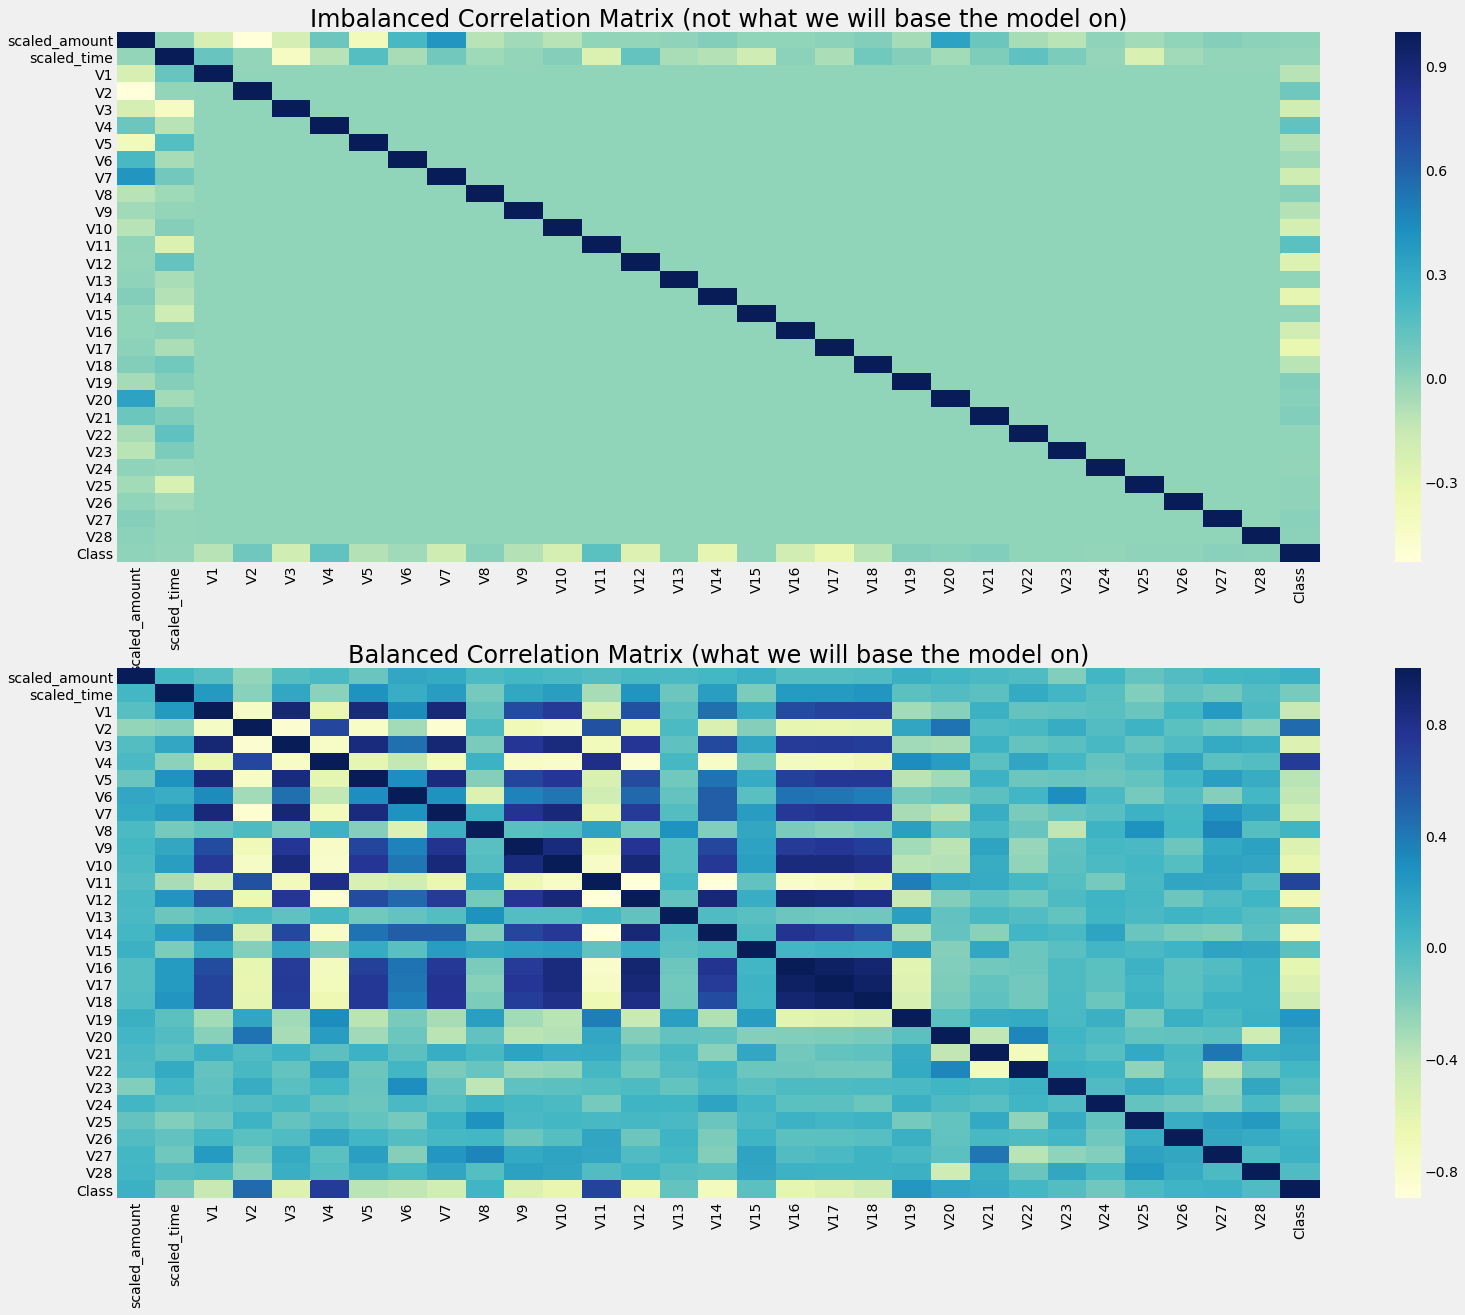

In [73]:
f, (ax1, ax2) = plt.subplots(2,1,figsize=(24,20))

correlation = Maindf.corr()
sns.heatmap(correlation, cmap='YlGnBu', annot_kws={'size' :20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix (not what we will base the model on)", fontsize=24)

undersample_corr = training_df.corr()
sns.heatmap(undersample_corr, cmap='YlGnBu', annot_kws={'size' :20}, ax=ax2)
ax2.set_title("Balanced Correlation Matrix (what we will base the model on)", fontsize=24)
plt.show()

### And now output the highest and lowest absolute correlations to visualize in a box and whisker plot

In [74]:
#code comes from 
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

def remove_diag(training_df):
    pairs_to_drop = set()
    cols = training_df.columns
    for i in range(0, training_df.shape[1]):
        for j in range(0, i + 1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_correlations(training_df, n=10):
    corr_parser = undersample_corr.abs().unstack()
    labels_to_drop = remove_diag(training_df)
    corr_parser = corr_parser.drop(labels=labels_to_drop).sort_values(kind = 'quicksort', ascending=False)
    return corr_parser[0:n]


In [75]:
print("Top Absolute Correlations")
print(get_top_correlations(training_df, 10))

Top Absolute Correlations
V16  V17    0.951584
V17  V18    0.946755
V16  V18    0.909921
V12  V16    0.905507
V11  V12    0.897337
     V14    0.894667
V3   V7     0.888369
V1   V3     0.885346
V10  V12    0.881369
V12  V17    0.880415
dtype: float64


### Let's look at the correlations with the highest proportional and inverse relationships with the 'Class' column

In [76]:
training_df.shape

(804, 31)

Text(0.5, 1.0, 'V2 vs Class Pos Corr')

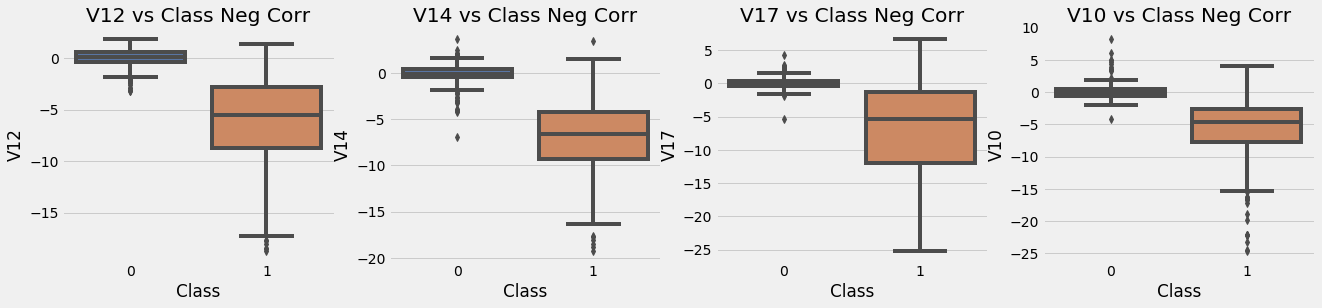

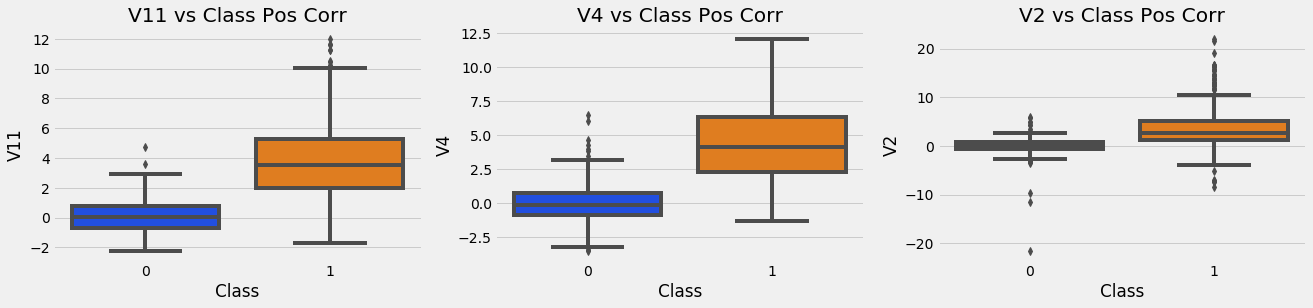

In [77]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

####################Lowest Negative Correlation#######################

sns.boxplot(x="Class", y="V12", data=training_df, palette='deep', ax=axes[0])
axes[0].set_title('V12 vs Class Neg Corr')

sns.boxplot(x="Class", y="V14", data=training_df, palette='deep', ax=axes[1])
axes[1].set_title('V14 vs Class Neg Corr')

sns.boxplot(x="Class", y="V17", data=training_df, palette='deep', ax=axes[2])
axes[2].set_title('V17 vs Class Neg Corr')

sns.boxplot(x="Class", y="V10", data=training_df, palette='deep', ax=axes[3])
axes[3].set_title('V10 vs Class Neg Corr')

############### Highest Positive Correlations#######################
f, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=training_df, palette='bright', ax=axes[0])
axes[0].set_title('V11 vs Class Pos Corr')

sns.boxplot(x="Class", y="V4", data=training_df, palette='bright', ax=axes[1])
axes[1].set_title('V4 vs Class Pos Corr')

sns.boxplot(x="Class", y="V2", data=training_df, palette='bright', ax=axes[2])
axes[2].set_title('V2 vs Class Pos Corr')


### Now time to remove extreme outliers

# need to figure out correlation relationships and why normalizing only the negatives matter

C:\Users\karan\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


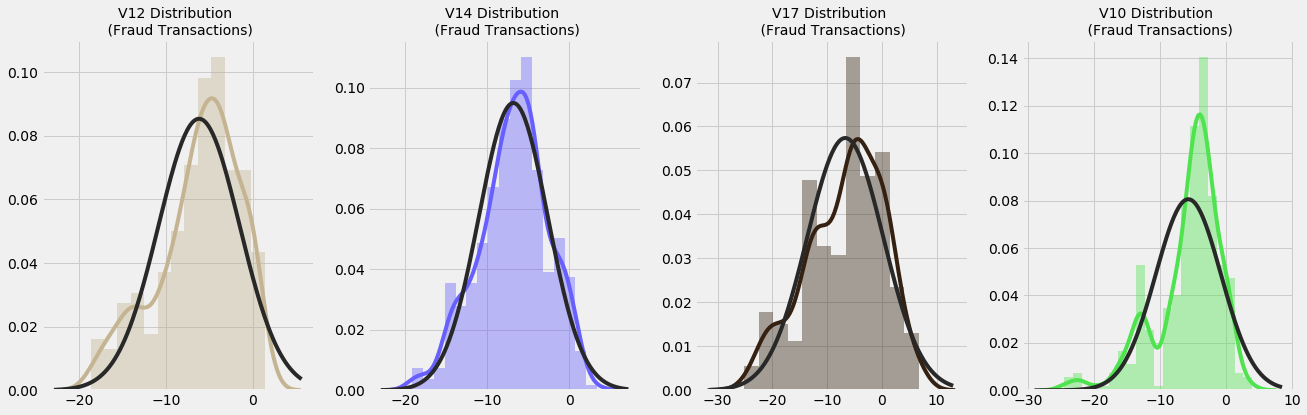

In [78]:
#2 methods of removing outliers....removing outliers from a normal distribution that are within 3 std from the mean
#or using the IQR for non-normal distrubtions
#First let's find out which ones have a normal distribution

f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(20, 6))

v12_distrib = training_df['V12'].loc[training_df['Class'] == 1].values
sns.distplot(v12_distrib, ax=ax1, fit=norm, color='#C5B491')
ax1.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v14_distrib = training_df['V14'].loc[training_df['Class'] == 1].values
sns.distplot(v14_distrib, ax=ax2, fit=norm, color='#685FFF')
ax2.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v17_distrib = training_df['V17'].loc[training_df['Class'] == 1].values
sns.distplot(v17_distrib, ax=ax3, fit=norm, color='#342111')
ax3.set_title('V17 Distribution \n (Fraud Transactions)', fontsize=14)

v10_distrib = training_df['V10'].loc[training_df['Class'] == 1].values
sns.distplot(v10_distrib, ax=ax4, fit=norm, color='#4FE34F')
ax4.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()


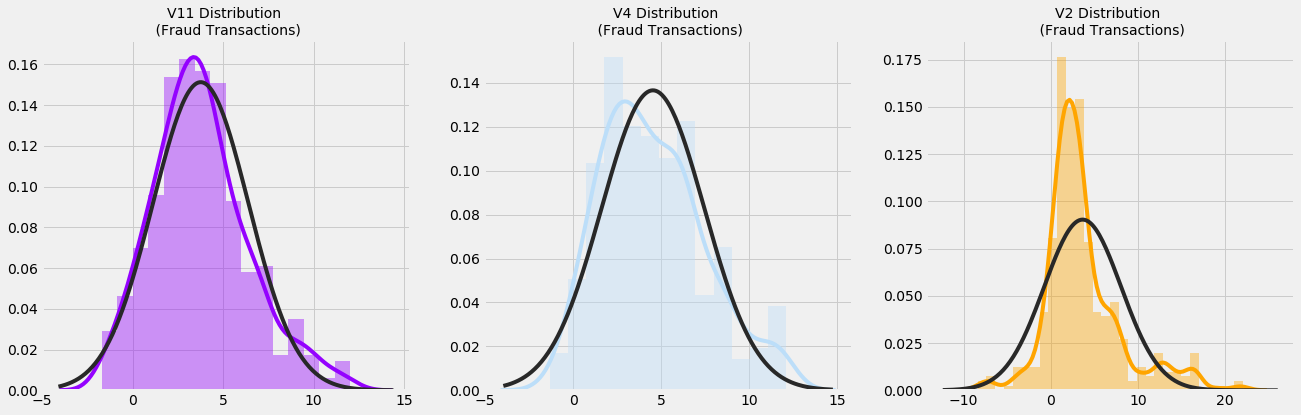

In [79]:
f, (ax5, ax6, ax7) = plt.subplots(1,3, figsize=(20, 6))

v11_distrib = training_df['V11'].loc[training_df['Class'] == 1].values
sns.distplot(v11_distrib, ax=ax5, fit=norm, color='#9402FF')
ax5.set_title('V11 Distribution \n (Fraud Transactions)', fontsize=14)

v4_distrib = training_df['V4'].loc[training_df['Class'] == 1].values
sns.distplot(v4_distrib, ax=ax6, fit=norm, color='#BCDEF9')
ax6.set_title('V4 Distribution \n (Fraud Transactions)', fontsize=14)

v2_distrib = training_df['V2'].loc[training_df['Class'] == 1].values
sns.distplot(v2_distrib, ax=ax7, fit=norm, color='orange')
ax7.set_title('V2 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()


# Changes to apply *********** maybe change the iqr multiplier to 1.5, look at clustering examples and look further into positive and neg correlations

In [80]:
#remove the outliers from the negative correlations first and adjust the multiplier for the IQR
#First remove outliers from V12
print('V12 Outlier removal')
print('')
v12_fraud = training_df['V12'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v12_iqr))

v12_threshold = v12_iqr * 2.5
v12_lower, v12_upper = q25 - v12_threshold, q75 + v12_threshold
print('Threshold: {}'.format(v12_threshold))
print('V12 lower: {}'.format(v12_lower))
print('V12 upper: {}'.format(v12_upper))

v12_outliers=[x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Feature V12 outliers for Fraud Cases: {}'.format(len(v12_outliers)))
print('V12 outliers: {}'.format(v12_outliers))

training_df = training_df.drop(training_df[(training_df['V12'] > v12_upper) | (training_df['V12'] < v12_lower)].index)

print('')
print('')

print('###################################################################')
print('V14 Outlier removal')
print('')
v14_fraud = training_df['V14'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v14_iqr))

v14_threshold = v14_iqr * 2.5
v14_lower, v14_upper = q25 - v14_threshold, q75 + v14_threshold
print('Threshold: {}'.format(v14_threshold))
print('V14 lower: {}'.format(v14_lower))
print('V14 upper: {}'.format(v14_upper))

v14_outliers=[x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 outliers for Fraud Cases: {}'.format(len(v14_outliers)))
print('V14 outliers: {}'.format(v14_outliers))

training_df = training_df.drop(training_df[(training_df['V14'] > v14_upper) | (training_df['V14'] < v14_lower)].index)

print('')
print('')

print('###################################################################')
print('V17 Outlier removal')
print('')

v17_fraud = training_df['V17'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v17_fraud, 25), np.percentile(v17_fraud, 75)
v17_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v17_iqr))

v17_threshold = v17_iqr * 2.5
v17_lower, v17_upper = q25 - v17_threshold, q75 + v17_threshold
print('Threshold: {}'.format(v17_threshold))
print('V17 lower: {}'.format(v17_lower))
print('V17 upper: {}'.format(v17_upper))

v17_outliers=[x for x in v17_fraud if x < v17_lower or x > v17_upper]
print('Feature V17 outliers for Fraud Cases: {}'.format(len(v17_outliers)))
print('V17 outliers: {}'.format(v17_outliers))

training_df = training_df.drop(training_df[(training_df['V17'] > v17_upper) | (training_df['V17'] < v17_lower)].index)

print('')
print('')

print('###################################################################')
print('V10 Outlier removal')
print('')

v10_fraud = training_df['V10'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v10_iqr))

v10_threshold = v10_iqr * 2.5
v10_lower, v10_upper = q25 - v10_threshold, q75 + v10_threshold
print('Threshold: {}'.format(v10_threshold))
print('V10 lower: {}'.format(v10_lower))
print('V10 upper: {}'.format(v10_upper))

v10_outliers=[x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Feature V10 outliers for Fraud Cases: {}'.format(len(v10_outliers)))
print('V10 outliers: {}'.format(v10_outliers))

training_df = training_df.drop(training_df[(training_df['V10'] > v10_upper) | (training_df['V10'] < v10_lower)].index)

print('')
print('')



V12 Outlier removal

Quartile 25: -8.68160893168352 | Quartile 75: -2.8514370291960303 | iqr: 5.83017190248749
Threshold: 14.575429756218725
V12 lower: -23.257038687902245
V12 upper: 11.723992727022694
Feature V12 outliers for Fraud Cases: 0
V12 outliers: []


###################################################################
V14 Outlier removal

Quartile 25: -9.262666950577973 | Quartile 75: -4.213908422208075 | iqr: 5.048758528369898
Threshold: 12.621896320924746
V14 lower: -21.88456327150272
V14 upper: 8.407987898716671
Feature V14 outliers for Fraud Cases: 0
V14 outliers: []


###################################################################
V17 Outlier removal

Quartile 25: -11.939091505211598 | Quartile 75: -1.357082637713495 | iqr: 10.582008867498104
Threshold: 26.45502216874526
V17 lower: -38.39411367395686
V17 upper: 25.097939531031763
Feature V17 outliers for Fraud Cases: 0
V17 outliers: []


###################################################################
V10 Outlier r

In [81]:
#remove the outliers from the positive correlations and adjust the multiplier
#First remove outliers from V11
print('V11 Outlier removal')
print('')
v11_fraud = training_df['V11'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v11_iqr))

v11_threshold = v11_iqr * 2.5
v11_lower, v11_upper = q25 - v11_threshold, q75 + v11_threshold
print('Threshold: {}'.format(v11_threshold))
print('V12 lower: {}'.format(v11_lower))
print('V12 upper: {}'.format(v11_upper))

v11_outliers=[x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Feature V11 outliers for Fraud Cases: {}'.format(len(v11_outliers)))
print('V12 outliers: {}'.format(v11_outliers))

training_df = training_df.drop(training_df[(training_df['V11'] > v11_upper) | (training_df['V11'] < v11_lower)].index)

print('')
print('')

print('###################################################################')
print('V4 Outlier removal')
print('')
v4_fraud = training_df['V4'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
v4_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v4_iqr))

v4_threshold = v4_iqr * 2.5
v4_lower, v4_upper = q25 - v4_threshold, q75 + v4_threshold
print('Threshold: {}'.format(v4_threshold))
print('V4 lower: {}'.format(v4_lower))
print('V4 upper: {}'.format(v4_upper))

v4_outliers=[x for x in v4_fraud if x < v4_lower or x > v4_upper]
print('Feature V4 outliers for Fraud Cases: {}'.format(len(v4_outliers)))
print('V4 outliers: {}'.format(v4_outliers))

training_df = training_df.drop(training_df[(training_df['V4'] > v4_upper) | (training_df['V4'] < v4_lower)].index)

print('')
print('')

print('###################################################################')
print('V2 Outlier removal')
print('')
v2_fraud = training_df['V2'].loc[training_df['Class'] == 1].values
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
v2_iqr= q75 - q25
print('Quartile 25: {} | Quartile 75: {} | iqr: {}'.format(q25, q75, v2_iqr))

v2_threshold = v2_iqr * 2.5
v2_lower, v2_upper = q25 - v2_threshold, q75 + v2_threshold
print('Threshold: {}'.format(v2_threshold))
print('V2 lower: {}'.format(v2_lower))
print('V2 upper: {}'.format(v2_upper))

v2_outliers=[x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Feature V2 outliers for Fraud Cases: {}'.format(len(v2_outliers)))
print('V2 outliers: {}'.format(v2_outliers))

training_df = training_df.drop(training_df[(training_df['V2'] > v2_upper) | (training_df['V2'] < v2_lower)].index)

print('')
print('')

print('Number of instances after outliers are removed: {}'.format(len(training_df)))



V11 Outlier removal

Quartile 25: 1.96902851817358 | Quartile 75: 5.303053601119871 | iqr: 3.3340250829462903
Threshold: 8.335062707365726
V12 lower: -6.3660341891921455
V12 upper: 13.638116308485596
Feature V11 outliers for Fraud Cases: 0
V12 outliers: []


###################################################################
V4 Outlier removal

Quartile 25: 2.2766625190219445 | Quartile 75: 6.255597156263825 | iqr: 3.9789346372418803
Threshold: 9.947336593104701
V4 lower: -7.670674074082757
V4 upper: 16.202933749368526
Feature V4 outliers for Fraud Cases: 0
V4 outliers: []


###################################################################
V2 Outlier removal

Quartile 25: 1.1815663129811802 | Quartile 75: 4.570695884419235 | iqr: 3.389129571438055
Threshold: 8.472823928595139
V2 lower: -7.291257615613958
V2 upper: 13.043519813014374
Feature V2 outliers for Fraud Cases: 16
V2 outliers: [16.7133892350242, 15.876922987953598, 13.4873857909274, 15.3658043803315, 14.7063346696674, 14.3232

### Recreated the boxplot but now notice the changes in the scale of the outliers from the prior set of boxplots

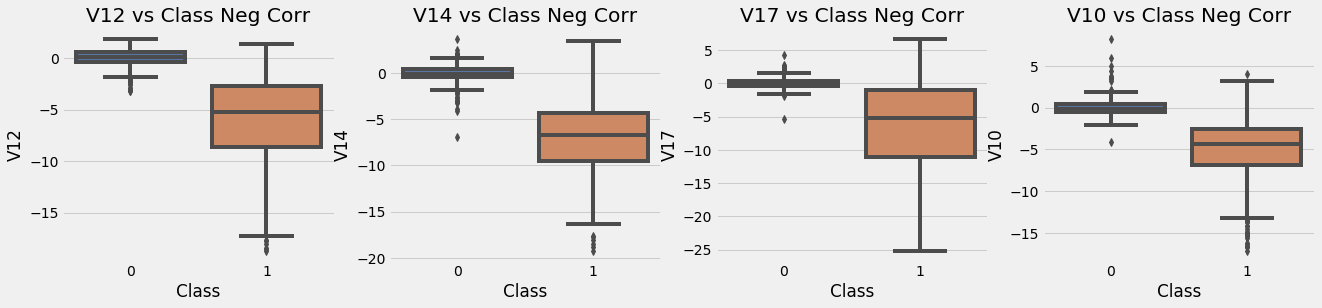

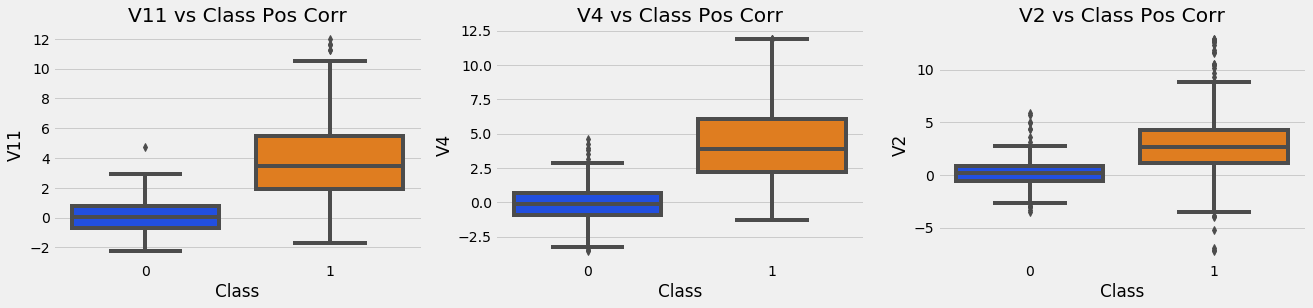

In [82]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

####################Lowest Negative Correlation#######################

sns.boxplot(x="Class", y="V12", data=training_df, palette='deep', ax=axes[0])
axes[0].set_title('V12 vs Class Neg Corr')

sns.boxplot(x="Class", y="V14", data=training_df, palette='deep', ax=axes[1])
axes[1].set_title('V14 vs Class Neg Corr')

sns.boxplot(x="Class", y="V17", data=training_df, palette='deep', ax=axes[2])
axes[2].set_title('V17 vs Class Neg Corr')

sns.boxplot(x="Class", y="V10", data=training_df, palette='deep', ax=axes[3])
axes[3].set_title('V10 vs Class Neg Corr')

############### Highest Positive Correlations#######################
f, axes = plt.subplots(ncols=3, figsize=(20,4))

sns.boxplot(x="Class", y="V11", data=training_df, palette='bright', ax=axes[0])
axes[0].set_title('V11 vs Class Pos Corr')

sns.boxplot(x="Class", y="V4", data=training_df, palette='bright', ax=axes[1])
axes[1].set_title('V4 vs Class Pos Corr')

sns.boxplot(x="Class", y="V2", data=training_df, palette='bright', ax=axes[2])
axes[2].set_title('V2 vs Class Pos Corr')

plt.show()

# Let's try clustering the dataset to see which clustering algorithms would best pre-process the dataset for optimal ML results

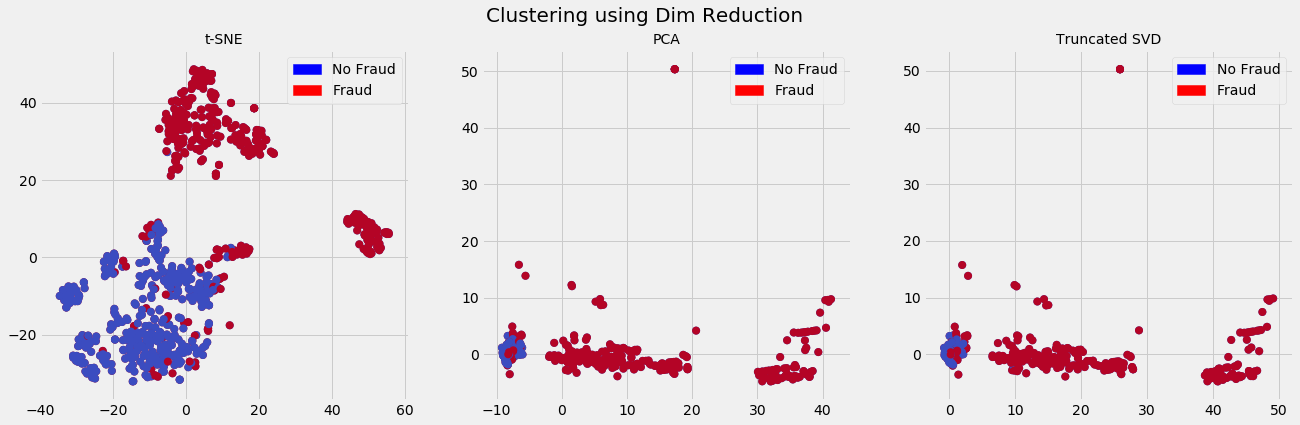

In [83]:
X = training_df.drop('Class', axis=1)
y = training_df['Class']

#implementing a T-SNE
X_reduced_tsne = TSNE(n_components = 2, random_state = 13).fit_transform(X.values)

#implementing PCA
X_reduced_pca = PCA(n_components = 2, random_state = 13).fit_transform(X.values)

#implementing Truncated SVD
X_reduced_truncSVD = TruncatedSVD(n_components = 2, algorithm='randomized', random_state = 13).fit_transform(X.values)

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))
#labels = ['No Fraud', 'Fraud']
f.suptitle('Clustering using Dim Reduction', fontsize=20)

blue_patch = mpatches.Patch(color='blue', label='No Fraud')
red_patch = mpatches.Patch(color='red', label='Fraud')

#t-sne scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])

#PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

#truncated SVD scatter plot
ax3.scatter(X_reduced_truncSVD[:,0], X_reduced_truncSVD[:,1], c=(y==0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_truncSVD[:,0], X_reduced_truncSVD[:,1], c=(y==1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

### It's interesting that t-SNE is outperforming PCA and Truncated SVD considering that t-SNE is primarily used for very high dimensionality.  I would have thought that 30 features would not be enough for t-SNE to be effective compared to PCA.

## Now let's finally implement a few basic classifiers

In [84]:
#Undersampling before cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13)

#changing the values into an array for the classifiers
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

classifiers = {
    'LogisticRegression': LogisticRegression(),
    'KNearest':KNeighborsClassifier(),
    'Support Vector Classifier': SVC()
}


In [85]:
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv =5)
    print("Classifiers: ", classifier.__class__.__name__, ' has a training score of ', round(training_score.mean(), 2)*100, '% accuracy')

Classifiers:  LogisticRegression  has a training score of  95.0 % accuracy
Classifiers:  KNeighborsClassifier  has a training score of  94.0 % accuracy
Classifiers:  SVC  has a training score of  94.0 % accuracy


C:\Users\karan\Anaconda3\envs\DeepLearn\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\karan\Anaconda3\envs\DeepLearn\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\karan\Anaconda3\envs\DeepLearn\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\karan\Anaconda3\envs\DeepLearn\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\karan\Anaconda3\envs\DeepLearn\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Defau

## Now time to oversample using SMOTE.  Since I'm having trouble importing a SMOTE library, it's time to roll up my sleeves and create my own SMOTE function(s)

In [86]:
fraud_train

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
42936,0.526514,-0.509722,-12.980943,6.720508,-13.455636,8.698610,-11.479552,-2.681519,-14.019291,8.218191,...,-0.843303,2.549628,-0.532228,-0.235096,0.673209,0.226598,-0.006168,-1.185696,-0.747361,1
12369,-0.293440,-0.740493,-18.018561,10.558600,-24.667741,11.786180,-10.564657,-2.645681,-18.023468,2.693655,...,1.007703,-2.319479,0.908839,1.352904,-1.059222,0.185751,0.687037,2.078081,-1.429517,1
279863,5.142178,0.992140,-1.927883,1.125653,-4.518331,1.749293,-1.566487,-2.010494,-0.882850,0.697211,...,1.252967,0.778584,-0.319189,0.639419,-0.294885,0.537503,0.788395,0.292680,0.147968,1
118308,0.113743,-0.113476,-0.430330,0.985633,0.645789,0.317131,0.616332,-1.347462,1.078234,-0.161518,...,-0.115282,-0.016378,-0.207609,-0.164119,0.255280,0.454798,-0.505032,-0.039456,-0.006358,1
237107,-0.307413,0.756635,1.184891,3.152084,-6.134780,5.531252,1.733867,-1.816861,-0.916696,0.265568,...,0.336442,0.124236,-0.823865,-0.079887,0.028828,0.389711,0.060171,0.485187,0.326552,1
281144,3.116048,1.001821,-3.113832,0.585864,-5.399730,1.817092,-0.840618,-2.943548,-2.208002,1.058733,...,0.306271,0.583276,-0.269209,-0.456108,-0.183659,-0.328168,0.606116,0.884876,-0.253700,1
96994,-0.202194,-0.219164,0.286302,1.399345,-1.682503,3.864377,-1.185373,-0.341732,-2.539380,0.768378,...,0.270360,0.352456,-0.243678,-0.194079,-0.172201,0.742237,0.127790,0.569731,0.291206,1
218442,2.426605,0.665280,-6.352337,-2.370335,-4.875397,2.335045,-0.809555,-0.413647,-4.082308,2.239089,...,0.186898,1.325218,1.226745,-1.485217,-1.470732,-0.240053,0.112972,0.910591,-0.650944,1
163149,-0.069028,0.364184,-1.550273,1.088689,-2.393388,1.008733,-1.087562,-1.104602,-2.670503,0.147655,...,0.327490,0.802316,1.037105,0.095815,-0.320191,-0.080731,0.091012,0.024928,-0.077820,1
42674,-0.286173,-0.511026,-7.896886,5.381020,-8.451162,7.963928,-7.862419,-2.376820,-11.949723,5.051356,...,0.645974,2.557944,0.926278,0.032795,0.638073,0.361887,0.444577,1.101923,0.205958,1


In [87]:
import random
from sklearn.neighbors import NearestNeighbors


In [94]:
Y_fraud_train = fraud_train['Class']

In [88]:
k_num = 5

In [90]:
def nearest_neighbor(data):
    neighbors=NearestNeighbors(n_neighbors = k_num, metric='euclidean', algorithm='kd_tree').fit(data)
    euclidean, indices = neighbors.kneighbors(data)
    return indices

In [91]:
print(nearest_neighbor(fraud_train).shape)

(402, 5)


In [111]:
def simple_SMOTE(data):
    indices2 = nearest_neighbor(data)
    matrix = []
    
    for val in range (len(indices2)):
        k = x1[indices2[val]]
        newt = pd.DataFrame(k)
        matrix.append([])
        for j in range(len(newt.columns)):
            matrix[val].append(random.choice(newt[j]))
    return matrix

In [112]:
unique, counts = np.unique(Y_fraud_train, return_counts=True)

In [113]:
fraud_shape = dict(zip(unique, counts))[1]

In [114]:
x1 = np.ones((fraud_shape, fraud_train.shape[1]))
x1 = [fraud_train.iloc[i] for i, p in enumerate(Y_fraud_train) if p ==1.0]
x1 = np.array(x1)

In [116]:
sampled_instances = simple_SMOTE(x1)

fraud_train_SMOTE = np.concatenate((fraud_train, sampled_instances), axis = 0)

In [118]:
y_sampled_instances = np.ones(minority_shape)
y_Train_SMOTE = np.concatenate((Y_fraud_train, y_sampled_instances), axis = 0)

In [120]:
y_Train_SMOTE

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### Now implementing Log Reg on SMOTE oversampled data

In [45]:

from sklearn.model_selection import RandomizedSearchCV

In [122]:
log_reg_sm = LogisticRegression()

log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


In [129]:
sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train, test in sss.split(X, y):
    pipeline = imbalanced_make_pipeline(y_Train_SMOTE, rand_log_reg)

NameError: name 'imbalanced_make_pipeline' is not defined

In [127]:
y

10690     1
163628    0
70316     0
243393    1
63352     0
261056    1
203328    1
119714    1
243848    1
11071     0
10497     1
189878    1
150654    1
143838    0
150665    1
17517     0
8842      1
237107    1
142557    1
120837    1
30153     0
241888    0
27362     1
114578    0
270673    0
128479    1
235644    1
162972    0
53573     0
69498     1
         ..
92891     0
268375    1
106677    0
194012    0
191690    1
43061     1
63634     1
106585    0
203700    1
157387    0
12369     1
141257    1
269965    0
149522    1
161968    0
263324    1
42007     1
45686     0
82571     0
150661    1
227972    0
127769    0
88258     1
52299     0
72757     1
204767    0
134542    0
84843     0
56703     1
8296      1
Name: Class, Length: 778, dtype: int64

In [130]:
import imblearn

ModuleNotFoundError: No module named 'imblearn'